In [214]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings 
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

In [215]:
train = pd.read_csv('train_processed.csv')
test = pd.read_csv('test_processed.csv')
valid = pd.read_csv('valid_processed.csv')


In [218]:
test.shape

(10948, 26)

In [219]:
train.columns

Index(['IsBadBuy', 'VehicleAge', 'Size', 'VehBCost', 'WarrantyCost',
       'CostPerMile', 'WarrantyPerMile', 'CostPerYear', 'VehOdo_Standard',
       'Adesa_Auction', 'make_CHEVROLET', 'make_CHRYSLER', 'make_DODGE',
       'make_FORD', 'make_HYUNDAI', 'make_JEEP', 'make_KIA', 'make_NISSAN',
       'make_PONTIAC', 'make_SATURN', 'make_other', 'TrimCategory_Encoded',
       'Alloy', 'Covers', 'isAmerican', 'MMRAverage'],
      dtype='object')

undersample = RandomUnderSampler(sampling_strategy={0: int(Counter(train_y)[0] * 0.67)}, random_state=42)
X_under, y_under = undersample.fit_resample(train_x, train_y)


smote = SMOTE(sampling_strategy={1: int(Counter(y_under)[1] * 1.6)}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)


print("Distribucija pre resamplinga: %d, %d" %(train.shape[0],train.loc[train['IsBadBuy']==1].shape[0]))
print("Distribucija nakon resamplinga:", Counter(y_resampled))

train_resampled = X_resampled
train_resampled['IsBadBuy'] = y_resampled

plt.figure(figsize=(8, 5))
counts = train_resampled['IsBadBuy'].value_counts(normalize=True) * 100  
plt.pie(counts, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=140, colors=['lightblue', 'pink'])
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
plt.title('Distribucija ciljne promenljive (procentualno)')
plt.show()

Sprovescemo K means algoritam za vrednosti k od 2 do 16, kako bismo videli optimalno K. Odredicemo ga pomocu SSE 

In [220]:
train_klasterovanje = train[['CostPerMile','WarrantyPerMile','CostPerYear',"VehicleAge", "VehOdo_Standard", "VehBCost", "WarrantyCost", "MMRAverage"]]

In [221]:
sse_list = list()
max_k = 10
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_klasterovanje)
    sse = kmeans.inertia_
    sse_list.append(sse)

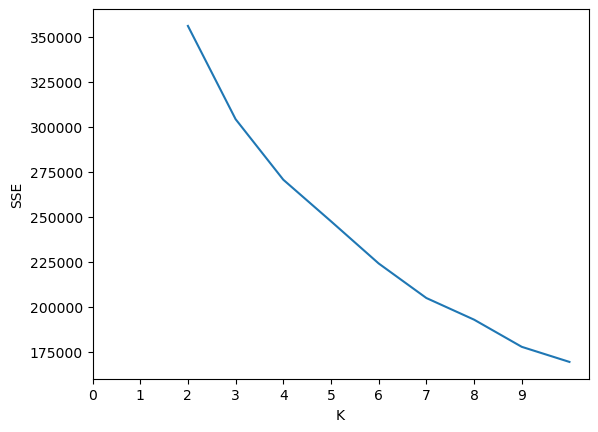

In [222]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.xticks(np.arange(0, 10, 1))
plt.tick_params(axis='both', which='major')
plt.show()

Na lakat krivi se nijedna vrednost K ne izdvaja posebno, tako da cemo uzeti da je vrednost 3.

In [223]:
kmeans = KMeans(n_clusters = 3, n_init=10, max_iter = 100, random_state = 1)
kmeans.fit(train_klasterovanje)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=1)

In [224]:
labels, sizes = np.unique(kmeans.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %d: %s (%.2f)' % (l, s, s/len(train_klasterovanje)))

Cluster 0: 9973 (0.20)
Cluster 1: 23303 (0.46)
Cluster 2: 17812 (0.35)


In [225]:

train_klasterovanje['y'] = train['IsBadBuy']
train_klasterovanje["label"] = kmeans.labels_
train_klasterovanje.groupby("label").mean()

,CostPerMile,WarrantyPerMile,CostPerYear,VehicleAge,VehOdo_Standard,VehBCost,WarrantyCost,MMRAverage,y
label,,,,,,,,,
0,-0.572887,0.722968,-0.950017,6.623082,0.092959,-0.656915,0.864424,-0.865786,0.219292
1,-0.192588,-0.373361,-0.389048,4.270223,-0.102753,-0.300756,-0.358065,-0.318374,0.121959
2,0.572720,0.083667,1.040899,2.673366,0.082381,0.761281,-0.015546,0.901278,0.070963


In [226]:
label_map = {0: 2, 1: 1, 2: 0}
train_klasterovanje['label'] = train_klasterovanje['label'].map(label_map)
train_klasterovanje.groupby("label").mean()

,CostPerMile,WarrantyPerMile,CostPerYear,VehicleAge,VehOdo_Standard,VehBCost,WarrantyCost,MMRAverage,y
label,,,,,,,,,
0,0.572720,0.083667,1.040899,2.673366,0.082381,0.761281,-0.015546,0.901278,0.070963
1,-0.192588,-0.373361,-0.389048,4.270223,-0.102753,-0.300756,-0.358065,-0.318374,0.121959
2,-0.572887,0.722968,-0.950017,6.623082,0.092959,-0.656915,0.864424,-0.865786,0.219292


In [227]:
train['Cluster'] = train_klasterovanje['label']

In [228]:
train.head()

,IsBadBuy,VehicleAge,Size,VehBCost,WarrantyCost,CostPerMile,WarrantyPerMile,CostPerYear,VehOdo_Standard,Adesa_Auction,...,make_NISSAN,make_PONTIAC,make_SATURN,make_other,TrimCategory_Encoded,Alloy,Covers,isAmerican,MMRAverage,Cluster
0,0,3,2,0.421311,1.160929,0.029310,1.153278,0.437552,0.331758,0,...,False,False,False,False,1,1,0,1,1.108157,0
1,0,3,1,-1.154650,0.185613,-0.835121,0.066493,-0.421819,0.420841,0,...,False,False,False,False,0,0,1,1,-0.529157,1
2,0,3,5,0.699088,-0.596307,0.294655,-0.654293,0.589024,0.074933,0,...,False,False,False,False,1,1,0,1,1.146322,0
3,0,4,1,-0.871204,-0.374569,-0.961328,-0.855236,-0.588748,1.475867,0,...,False,False,False,False,0,1,0,1,-0.446700,1
4,1,3,2,-0.060548,0.380676,-0.300364,0.218226,0.174795,0.539168,1,...,False,False,False,False,0,1,0,1,-0.157577,1


In [229]:
valid_klasterovanje = valid[['CostPerMile','WarrantyPerMile','CostPerYear',"VehicleAge", "VehOdo_Standard", "VehBCost", "WarrantyCost", "MMRAverage"]]
test_klasterovanje = test[['CostPerMile','WarrantyPerMile','CostPerYear',"VehicleAge", "VehOdo_Standard", "VehBCost", "WarrantyCost", "MMRAverage"]]

In [230]:
valid_kmeans = kmeans.fit(valid_klasterovanje)



In [231]:
labels, sizes = np.unique(valid_kmeans.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %d: %s (%.2f)' % (l, s, s/len(valid_klasterovanje)))

Cluster 0: 3795 (0.35)
Cluster 1: 4993 (0.46)
Cluster 2: 2159 (0.20)


In [232]:
valid_klasterovanje['y'] = valid['IsBadBuy']
valid_klasterovanje["label"] = valid_kmeans.labels_
valid_klasterovanje.groupby("label").mean()

,CostPerMile,WarrantyPerMile,CostPerYear,VehicleAge,VehOdo_Standard,VehBCost,WarrantyCost,MMRAverage,y
label,,,,,,,,,
0,0.586477,0.039896,1.033086,2.662187,0.042443,0.748066,-0.068325,0.893878,0.068511
1,-0.234858,-0.369329,-0.409495,4.285400,-0.054654,-0.338004,-0.337416,-0.336113,0.129982
2,-0.543602,0.748184,-0.956501,6.698008,0.033236,-0.648747,0.856458,-0.891607,0.197777


In [233]:
valid['Cluster'] = valid_klasterovanje['label']

In [234]:
test_kmeans = kmeans.fit(test_klasterovanje)

In [235]:
test_klasterovanje['y'] = test['IsBadBuy']
test_klasterovanje["label"] = test_kmeans.labels_
test_klasterovanje.groupby("label").mean()

,CostPerMile,WarrantyPerMile,CostPerYear,VehicleAge,VehOdo_Standard,VehBCost,WarrantyCost,MMRAverage,y
label,,,,,,,,,
0,0.569202,0.059583,1.002096,2.743673,0.076389,0.786193,-0.029080,0.898936,0.068153
1,-0.532148,0.728076,-0.919996,6.569604,0.069914,-0.585167,0.859482,-0.807302,0.211894
2,-0.229651,-0.412677,-0.409376,4.228931,-0.112687,-0.384665,-0.399479,-0.372635,0.126734


In [236]:
label_map = {0: 0, 1: 2, 2: 1}
test_klasterovanje['label'] = test_klasterovanje['label'].map(label_map)
test_klasterovanje.groupby("label").mean()

,CostPerMile,WarrantyPerMile,CostPerYear,VehicleAge,VehOdo_Standard,VehBCost,WarrantyCost,MMRAverage,y
label,,,,,,,,,
0,0.569202,0.059583,1.002096,2.743673,0.076389,0.786193,-0.029080,0.898936,0.068153
1,-0.229651,-0.412677,-0.409376,4.228931,-0.112687,-0.384665,-0.399479,-0.372635,0.126734
2,-0.532148,0.728076,-0.919996,6.569604,0.069914,-0.585167,0.859482,-0.807302,0.211894


In [237]:
test['Cluster'] = test_klasterovanje['label']

In [240]:
train.shape

(51088, 27)

In [241]:
train.to_csv('train_final.csv',index=False)
valid.to_csv('valid_final.csv',index=False)
test.to_csv('test_final.csv',index = False)